In [33]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug  3 19:03:01 2020

@author: youss
"""
import os
from typing import Text, Tuple
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor as gbm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy import cluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import random
import umap
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import pickle
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lasso

warnings.filterwarnings("ignore")


def drug_eff(studies, verbose = True, plot= True):
    study = studies[0].study
    name = "drugg_effect_model_summary_study_"+ studies[0].name
    plotname = "study_"+ studies[0].name
    if(len(studies) > 1):
        for st in studies[1:]:
              study = pd.concat([study, st.study])
        name = "drugg_effect_model_summary_all_studies"
        plotname = "all studies"
    if "LeadStatus" in study.columns:
        mean = study["numVisit"].mean()
        passed = study[(study["LeadStatus"] == 'Passed')]
        #Testing the drug effect doing some statistical analysis:
        model = ols(formula = "PANSS_Total ~ VisitDay + VisitDay:TxGroup", data = passed).fit()
        ols_summary = model.summary() 
        with open("Drug_effect/" + name + ".txt", "w") as f:
            f.write(ols_summary.as_text())
        if verbose:
            print(ols_summary)
    
        #Testing quadratic relation:
        # polynomial_features = PolynomialFeatures(degree=2)
        # x = passed[["VisitDay", "TxGroup"]]
        # xp = polynomial_features.fit_transform(x)
        # model_quad = sm.OLS(passed["PANSS_Total"], xp).fit()
        
        model_quad = ols(formula = "PANSS_Total ~ np.power(VisitDay,2) + np.power(VisitDay,2):TxGroup",
                                     data = passed).fit()
        ols_summary = model_quad.summary() 
        with open("Drug_effect/" + name + "_quad.txt", "w") as f:
            f.write(ols_summary.as_text())
        if verbose:
            print(ols_summary)
    
        #only choosing the passed assessments
        grp = passed.pivot_table(index='VisitDay',columns='TxGroup',aggfunc=np.mean)
        
        panss = grp["PANSS_Total"]
        panss.fillna(method='bfill',inplace=True)
        win = 10
        MA = panss.rolling(window=win).mean()
        if plot:
            fig, ax = plt.subplots(1,2,figsize=(16,7))
            
            ax[0].plot(panss.index, panss[0], '--m', label = 'Control')
            ax[0].plot(panss.index, panss[1], '--y', label = 'Treatment')
            ax[0].set_xlabel("VisitDay")
            ax[0].set_ylabel("Mean PANSS score")
            ax[0].set_title("Evolution of mean PANSS score with VisitDay for both groups " + plotname)
            ax[0].legend()
            
            ax[1].plot(panss.index, MA[0], '--m', label = 'Control')
            ax[1].plot(panss.index, MA[1], '--y', label = 'Treatment')
            ax[1].set_xlabel("VisitDay")
            ax[1].set_ylabel("Moving average (w="+str(win)+") PANSS score")
            ax[1].set_title("Evolution of MA (w="+str(win)+") PANSS score with VisitDay for both groups " + plotname)
            ax[1].legend()
            
            plt.savefig("Plots/"+ name, bbox_inches = 'tight', pad_inches = 0)
            plt.show() 
    
def kmeans(data, features, num_clusters):
    X = data.loc[:, features]
    y_pred = KMeans(n_clusters = num_clusters, random_state=170).fit_predict(X)
    if len(features) <=2 :
        plt.scatter(X[features[0]], X[features[1]], c=y_pred)
        plt.xlabel(features[0])
        plt.ylabel(features[1])
        plt.title("Clustering based on " + features[0] + " and " + features[1]) 
        plt.savefig("Plots/Clustering based on " + features[0] + " and " + features[1], bbox_inches = 'tight', pad_inches = 0)
        plt.show()
    else:
        fig = plt.figure(1)
        fig.clf()
        ax = Axes3D(fig)
        ax.scatter(X[features[0]], X[features[1]], X[features[2]], c=y_pred)
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        ax.set_title("Clustering based on " + features[0] + "," + features[1] + " and " + features[2])  
        plt.savefig("Plots/Clustering based on " + features[0] + "," + features[1] + " and " + features[2],
                        bbox_inches = 'tight', pad_inches = 0)
        plt.show()  

def classify(studies, k):
    study = studies[0].sum_feat[studies[0].sum_feat["VisitDay"] == 0]
    name = "drugg_effect_model_summary_study_"+ studies[0].name
    plot = "study_"+ studies[0].name
    if(len(studies) > 1):
        for st in studies[1:]:
              study = pd.concat([study, st.sum_feat[st.sum_feat["VisitDay"] == 0]])
        name = "drugg_effect_model_summary_all_studies.txt"
        plot = "all studies"
    
    #hierarchical clustering:
    if studies[0].name != 'E':
        data = study.drop(['Study', 'Country', 'AssessmentID','LeadStatus'], axis=1)
    else:
        data = study.drop(['Study', 'Country', 'AssessmentID'], axis=1)
    data = data.select_dtypes(exclude='string')
    scaled_var = preprocessing.scale(data)
    figure,_ = plt.subplots(figsize=(10, 10))
    clusters = cluster.hierarchy.linkage(scaled_var, 'complete')
    dendo = cluster.hierarchy.dendrogram(clusters, labels = data.index)
    
    study["p"] = study[["P1", "P2", "P6"]].sum(axis=1)
    study["g"] = study[["G9", "G15", "G16"]].sum(axis=1)
    study["n"] = study[["N3", "N2", "N5"]].sum(axis=1)
    
    
    #Clustering using different features
    #pos sum vs. neg sum
    kmeans(study, ['pos', 'neg'], num_clusters = k)
    
    #pos sum vs. gen sum
    kmeans(study, ['pos', 'gen'], num_clusters = k)
    
    #neg sum vs. gen sum
    kmeans(study, ['neg', 'gen'], num_clusters = k)
    
    #P2 vs PANSS_Total
    kmeans(study, ['P2', 'PANSS_Total'], num_clusters = k)
    
    #P6 vs PANSS_Total
    kmeans(study, ['P6', 'PANSS_Total'], num_clusters = k)
    
    #P2 vs P6
    kmeans(study, ['P2', 'P6'], num_clusters = k)  
    
    #P2 vs N3
    kmeans(study, ['P2', 'N3'], num_clusters = k)  

    #pos vs. neg vs. gen:
    kmeans(study, ['pos', 'neg', 'gen'], num_clusters = k) 
    
    #P2 vs. P6 vs. P1:
    kmeans(study, ['P1', 'P2', 'P6'], num_clusters = k) 
    
    #p vs. N3 vs. G9:
    kmeans(study, ['p', 'N3', 'G9'], num_clusters = k)     
    
    #p = P1 + P2 + P6 vs. n = N3 + N2 + N5 vs. g = G9 + G15 + G16:
    kmeans(study, ['p', 'n', 'g'], num_clusters = k)
    
    #P2 vs. P6 vs. PANSS_Total:
    kmeans(study, ['P2', 'P6', 'PANSS_Total'], num_clusters = k)  

    #P2 vs. N2 vs. PANSS_Total:
    kmeans(study, ['P2', 'N2', 'PANSS_Total'], num_clusters = k) 
    
    #P2 vs. G9 vs. PANSS_Total:
    kmeans(study, ['P2', 'G9', 'PANSS_Total'], num_clusters = k) 
    
    #RaterID effect on total score:
    kmeans(study, ['RaterID', 'PANSS_Total'], num_clusters = k)

    #SiteID effect on total score:
    kmeans(study, ['SiteID', 'PANSS_Total'], num_clusters = k)
        
def forecast(studies, featToexclude, mdName, granular=True, pca=False,
             alltrain = False, allstudies = False, featEng = False):
    study = studies[0].study_ewm if featEng else studies[0].study
    for st in studies[1:]:
        if featEng:
            study = pd.concat([study, st.study_ewm])
        else:
            study = pd.concat([study, st.study])
    if featEng:
        study = studies[-1].study_ewm if not allstudies else study
    else:
        study = studies[-1].study if not allstudies else study
    sorted_data = study.sort_values(by = ['PatientID', 'VisitDay'])
    train_X = sorted_data.loc[:,
                 ~study.columns.isin(featToexclude)]
    duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
    train_X = train_X[duplicate == True]
    
    train_y = sorted_data[['PANSS_Total', 'PatientID']]
    duplicate = train_y.duplicated(keep='first', subset=['PatientID'])  
    train_y = train_y[duplicate == True]
    train_ys = sorted_data[duplicate == True]
    
    if not alltrain:
        duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
        test_X = train_X[duplicate == False]
        train_X = train_X[duplicate == True]
        
        duplicate = train_y.duplicated(keep='first', subset=['PatientID'])  
        test_y = train_y[duplicate == False]
        train_y = train_y[duplicate == True]
        test_ys = train_ys[duplicate == False]
        train_ys = train_ys[duplicate == True]
    else:
        duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
        test_X = train_X[duplicate == False]
        
        duplicate = train_y.duplicated(keep='first', subset=['PatientID'])  
        test_y = train_y[duplicate == False]
        test_ys = train_ys[duplicate == False]
        
    test_X.drop('PatientID', axis=1, inplace = True)
    test_y.drop('PatientID', axis=1, inplace = True)
    train_X.drop('PatientID', axis=1, inplace = True)
    train_y.drop('PatientID', axis=1, inplace = True)
    
    #saving training df:
    train_X.to_csv("Train/train_X_"+ mdName +".csv", index=False)        
    train_y.to_csv("Train/train_y_"+ mdName +".csv", index=False)
    test_X.to_csv("Test/test_X_"+ mdName +".csv", index=False)    
    test_y.to_csv("Test/test_y_"+ mdName +".csv", index=False)
    
    models = {}

    if pca:
        pca = PCA(n_components=5)
        
        ft = test_X[features]
        test_X = StandardScaler().fit_transform(ft)
        test_X = pca.fit_transform(test_X)
        np.savetxt("Test/test_X_PCA.csv", test_X, delimiter=",")
        
        ft = train_X[features]
        train_X = StandardScaler().fit_transform(ft)
        train_X = pca.fit_transform(train_X)
        np.savetxt("Train/train_X_PCA.csv",train_X, delimiter=",")
        
    if granular:
        for feat in features:
            print("================================================================")
            print("Training the model for "+ feat)
            params = {'evalMetric':'rmse', 'silent':1}
            xgbr = xgb.XGBRegressor(**params)
            parameters = {
                      'objective':['reg:squarederror'],
                      'learning_rate': [.01], #so called `eta` value
                      'max_depth': [1],
                      'min_child_weight': [5],
                      'subsample': [0.7],
                      'colsample_bytree': [0.7],
                      'n_estimators': [700],
                      'gamma': [0.2],
                      'reg_alpha': [0.1], 
                      'verbosity': [0]}
            xgbr_grid = GridSearchCV(xgbr,
                                parameters,
                                cv = 3, 
                                refit = True,
                                verbose = False)
            
            #add to the fit parameters to perform early stopping:
            # , early_stopping_rounds=10,
            #               eval_set=[(train_X, train_ys[feat]), (test_X, test_ys[feat])]
            xgbr_grid.fit(train_X, train_ys[feat])
            xgbr = xgbr_grid.best_estimator_
            models[feat] = xgbr
            pickle.dump(xgbr, open("models/xgb_" + feat + "_" + mdName + ".dat", "wb"))
            
            
            #Decomment to plot the learning curves to use with early stoping:
            # results = xgbr.evals_result()
            # epochs = len(results['validation_0']['rmse'])
            # x_axis = range(0, epochs)
            # # plot log loss
            # fig, ax = plt.subplots()
            # ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
            # ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
            # ax.legend()
            # plt.ylabel('rmse')
            # plt.title('XGBoost rmse')
            # plt.savefig("models/xgb_" + feat + "_" + mdName)
            # plt.show()
            
        #predicting:
        if not alltrain:
            pred_y_ts = np.zeros(len(test_X))
        pred_y_tr = np.zeros(len(train_X))
        for feat in features:
            if not alltrain:
                pred_y_ts += models[feat].predict(test_X)
            pred_y_tr += models[feat].predict(train_X)
            
            
    if not granular:  
        print("================================================================")
        print("Training the model:")
        params = {'evalMetric': 'rmse'}
        xgbr = xgb.XGBRegressor(**params)
        parameters = {
                      'objective':['reg:squarederror'],
                      'learning_rate': [.01], #so called `eta` value
                      'max_depth': [1, 2],
                      'min_child_weight': [6],
                      'subsample': [0.7],
                      'colsample_bytree': [0.7],
                      'n_estimators': [600],
                      'gamma': [0.0, 0.25, 0.5, 1, 5],
                      'reg_alpha': [0.005, 0.01, 0.1, 1],
                      'verbose': [0]}
        xgbr_grid = GridSearchCV(xgbr,
                            parameters,
                            cv = 3,
                            verbose=False, 
                            refit = True)
        xgbr_grid.fit(train_X, train_y, early_stopping_rounds=10,
                          eval_set=[(train_X, train_y), (test_X, test_y)])
        xgbr = xgbr_grid.best_estimator_
        print(xgbr_grid.best_score_)
        print(xgbr_grid.best_params_)
        pickle.dump(xgbr, open("models/xgb_" + mdName + ".dat", "wb"))
        #predicting:
        if not alltrain:
            pred_y_ts = xgbr.predict(test_X)
            score_ts = xgbr.score(test_X, test_y.PANSS_Total)
            print("Test " + params["evalMetric"] + " score: " + str(score_ts))
        pred_y_tr = xgbr.predict(train_X)
        score_tr = xgbr.score(train_X, train_y)
        print("Training " + params["evalMetric"] + " score: " + str(score_tr))
        
        
        
    print("Training error: ")
    print("With round: " + str(np.mean((train_y.values - np.round(pred_y_tr))**2)))
    print("Without round: " + str(np.mean((train_y.values - pred_y_tr)**2)))    
    
    if not alltrain:
        print("Test error:")
        print("With round: " + str(np.mean((test_y.values - np.round(pred_y_ts))**2)))
        print("Without round: " + str(np.mean((test_y.values - pred_y_ts)**2)))
    
          
    #testing on Study_E:
    studyE = studies[-1].study_ewm  if featEng else studies[-1].study      
    sorted_data = studyE.sort_values(by = ['PatientID', 'VisitDay'])
    test_X_E = sorted_data.loc[:, ~studyE.columns.isin(featToexclude)]
    test_X_E.drop_duplicates(keep='last', subset=['PatientID'], inplace= True)  
    patientsID_E = test_X_E["PatientID"]
    test_X_E.drop('PatientID', axis=1, inplace = True)
    test_X_E.to_csv("Test/test_X_E"+ mdName +".csv", index=False)
    
    if pca:
        ft = test_X_E[features]
        test_X_E = StandardScaler().fit_transform(ft)
        test_X_E = pca.fit_transform(test_X_E)
    
    if not granular:
        pred_y_E = xgbr.predict(test_X_E)
    else:
        pred_y_E = np.zeros(len(test_X_E))
        for feat in features:
            pred_y_E += models[feat].predict(test_X_E)
    results = pd.DataFrame({"PatientID": patientsID_E.astype(int), "PANSS_Total": pred_y_E})
    results.to_csv("Submissions/submission_PANSS_"+ mdName +".csv", index=False)
    
def predict(file, mdName, features, study, featToexclude, oneModel):
    models = {}
    if not oneModel:
        for ft in features:
            models[ft] = pickle.load(open(file +"_"+ ft +"_"+ mdName + ".dat", 'rb'))
    else:
        models["1"] = pickle.load(open(file +"_"+ mdName + ".dat", 'rb'))
        features = ["1"]
        
    test_X = pd.read_csv("Test/test_X_"+ mdName +".csv")
    train_X = pd.read_csv("Train/train_X_"+ mdName +".csv")
    if mdName == "":
        test_X = pd.read_csv("Test/test_X_"+ mdName +".csv").drop(['SiteID', 'RaterID', 'PANSS_Total'], axis=1)
        train_X = pd.read_csv("Train/train_X_"+ mdName +".csv").drop(['SiteID', 'RaterID', 'PANSS_Total'], axis=1)
    test_y = pd.read_csv("Test/test_y_"+ mdName +".csv").PANSS_Total
    train_y = pd.read_csv("Train/train_y_"+ mdName +".csv").PANSS_Total
    
    pred_y_ts = np.zeros(len(test_X))
    pred_y_tr = np.zeros(len(train_X))
    for feat in features:
        pred_y_ts += models[feat].predict(test_X)
        pred_y_tr += models[feat].predict(train_X)
    print("Training error for model " + mdName + ":")
    print("With round: " + str(np.mean((train_y - np.round(pred_y_tr))**2)))
    print("Without round: " + str(np.mean((train_y - pred_y_tr)**2)))    
    
    
    print("Test error for model " + mdName + ":")
    print("With round: " + str(np.mean((test_y - np.round(pred_y_ts))**2)))
    print("Without round: " + str(np.mean((test_y - pred_y_ts)**2)))
        
        
    #Forecasting:
    studyE = study.study_ewm
    sorted_data = studyE.sort_values(by = ['PatientID', 'VisitDay'])
    temp = sorted_data.loc[:, ~studyE.columns.isin(featToexclude)]
    temp.drop_duplicates(keep='last', subset=['PatientID'], inplace= True)  
    patientsID_E = temp["PatientID"]
    test_X_E = pd.read_csv("test_X_Eno_feat_eng_alltrain_woPanss.csv")
    
    if mdName == "PCA":
        pca = PCA(n_components=5)
        ft = test_X_E[features]
        test_X_E = StandardScaler().fit_transform(ft)
        test_X_E = pca.fit_transform(test_X_E)

    pred_y_E = np.zeros(len(test_X_E))
    for feat in features:
        pred_y_E += models[feat].predict(test_X_E)
    results = pd.DataFrame({"PatientID": patientsID_E.astype(int), "PANSS_Total": pred_y_E})
    results.to_csv("Submissions/submission_PANSS_"+ mdName +".csv", index=False)
    return results

def ensembling(models, features, featuresToexclude, study_E):
    results = {}
    for mdName in models:
        results[mdName] = predict("models/xgb", mdName, features, study_E, featToexclude, False)
    PatientID_E = results[models[0]].PatientID
    pred_y_E = np.zeros(len(PatientID_E))
    for mdName in results:
        pred_y_E += results[mdName].PANSS_Total
    pred_y_E /= (len(models))
    
    results = pd.DataFrame({"PatientID": PatientID_E.astype(int), "PANSS_Total": pred_y_E})
    results.to_csv("Submissions/submission_PANSS_Ensemble.csv", index=False)
    
    
    
def forcaast_LR(studies, featToexclude, mdName, featEng = True,
                                    allstudies = False, alltrain = True, granular = True): 
    study = studies[0].study_ewm if featEng else studies[0].study
    for st in studies[1:]:
        if featEng:
            study = pd.concat([study, st.study_ewm])
        else:
            study = pd.concat([study, st.study])
            
    if featEng:
        study = studies[-1].study_ewm if not allstudies else study
    else:
        study = studies[-1].study if not allstudies else study
        
    sorted_data = study.sort_values(by = ['PatientID', 'VisitDay'])
    train_X = sorted_data.loc[:,
                 ~study.columns.isin(featToexclude)]
    duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
    train_X = train_X[duplicate == True]
    
    train_y = sorted_data[['PANSS_Total', 'PatientID']]
    duplicate = train_y.duplicated(keep='first', subset=['PatientID'])  
    train_y = train_y[duplicate == True]
    train_ys = sorted_data[duplicate == True]
    
    if not alltrain:
        duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
        test_X = train_X[duplicate == False]
        train_X = train_X[duplicate == True]
        
        duplicate = train_y.duplicated(keep='first', subset=['PatientID'])  
        test_y = train_y[duplicate == False]
        train_y = train_y[duplicate == True]
        test_ys = train_ys[duplicate == False]
        train_ys = train_ys[duplicate == True]
    else:
        duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
        test_X = train_X[duplicate == False]
        
        duplicate = train_y.duplicated(keep='first', subset=['PatientID'])  
        test_y = train_y[duplicate == False]
        test_ys = train_ys[duplicate == False]
        
    test_X.drop('PatientID', axis=1, inplace = True)
    test_y.drop('PatientID', axis=1, inplace = True)
    train_X.drop('PatientID', axis=1, inplace = True)
    train_y.drop('PatientID', axis=1, inplace = True)
    
    #saving training df:
    train_X.to_csv("Train/train_X_"+ mdName +".csv", index=False)        
    train_y.to_csv("Train/train_y_"+ mdName +".csv", index=False)
    test_X.to_csv("Test/test_X_"+ mdName +".csv", index=False)    
    test_y.to_csv("Test/test_y_"+ mdName +".csv", index=False)
    
    models = {}
    features = ['P1','P2','P3','P4','P5','P6','P7','N1','N2','N3','N4','N5','N6','N7',
                 'G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13',
                 'G14','G15','G16']
    if granular:
        for feat in features:
            print("================================================================")
            print("Training the model for " + feat)
            parameters = {'alpha': np.logspace(-2, 3, 20)}
            reg = ElasticNetCV(l1_ratio=1, alphas=parameters['alpha'],
                                     fit_intercept = True, cv=5)
    
            reg.fit(train_X, train_ys[feat])
            models[feat] = reg
            pickle.dump(reg, open("models/xgb_" + feat + "_" + mdName + ".dat", "wb"))
        #predicting:
        if not alltrain:
            pred_y_ts = np.zeros(len(test_X))
        pred_y_tr = np.zeros(len(train_X))
        for feat in features:
            if not alltrain:
                pred_y_ts += models[feat].predict(test_X)
            pred_y_tr += models[feat].predict(train_X)
        
    if not granular:  
        print("================================================================")
        print("Training the model:")
        parameters = {'alpha': np.logspace(-2, 3, 20)}
        reg = ElasticNetCV(l1_ratio=1, alphas=parameters['alpha'],
                           fit_intercept = True, cv=5)

        reg.fit(train_X, train_y)
        models = reg
        pickle.dump(reg, open("models/xgb_" + mdName + ".dat", "wb"))
        #predicting:
        if not alltrain:
            pred_y_ts = reg.predict(test_X)
            score_ts = reg.score(test_X, test_y.PANSS_Total)
        pred_y_tr = reg.predict(train_X)
        score_tr = reg.score(train_X, train_y)
        
    print("Training error: ")
    print("With round: " + str(np.mean((train_y.values - np.round(pred_y_tr))**2)))
    print("Without round: " + str(np.mean((train_y.values - pred_y_tr)**2)))    
    
    if not alltrain:
        print("Test error:")
        print("With round: " + str(np.mean((test_y.values - np.round(pred_y_ts))**2)))
        print("Without round: " + str(np.mean((test_y.values - pred_y_ts)**2)))
    
    
        
        
    #Forecasting:
    studyE = studies[-1].study_ewm
    sorted_data = studyE.sort_values(by = ['PatientID', 'VisitDay'])
    test_X_E = sorted_data.loc[:, ~studyE.columns.isin(featToexclude)]
    test_X_E.drop_duplicates(keep='last', subset=['PatientID'], inplace= True)  
    patientsID_E = test_X_E["PatientID"]
    test_X_E.drop('PatientID', axis=1, inplace = True)

    if not granular:
        pred_y_E = models.predict(test_X_E)
    else:
        pred_y_E = np.zeros(len(test_X_E))
        for feat in features:
            pred_y_E += models[feat].predict(test_X_E)
    results = pd.DataFrame({"PatientID": patientsID_E.astype(int), "PANSS_Total": pred_y_E})
    results.to_csv("Submissions/submission_PANSS_"+ mdName +".csv", index=False)

    
def classification(studies, featToexclude):
    target = 'LeadStatus'
    study = studies[0].study_ewm
    for st in studies[1:-1]:
        study = pd.concat([study, st.study_ewm])
    train_X = study.loc[:, ~study.columns.isin(featToexclude)]
    
    train_y = study[[target, 'PatientID']]
    
    duplicate = train_X.duplicated(keep='last', subset=['PatientID'])  
    test_X = train_X[duplicate == False]
    train_X = train_X[duplicate == True]
    
    duplicate = train_y.duplicated(keep='last', subset=['PatientID'])  
    test_y = train_y[duplicate == False]
    train_y = train_y[duplicate == True]
    
    lb = LabelEncoder()
    train_y[target] = lb.fit_transform(train_y[target])
    test_y[target]  = lb.fit_transform(test_y[target])
    
    train_X.drop(['PatientID', 'AssessmentID', 'LeadStatus'], axis=1, inplace = True)
    test_X.drop(['PatientID', 'AssessmentID', 'LeadStatus'], axis=1, inplace = True)
    train_y.drop('PatientID', axis=1, inplace = True)
    test_y.drop('PatientID', axis=1, inplace = True)
    
    xgbc = xgb.XGBClassifier(objective='multi:softmax')
    xgbc.fit(train_X, train_y.values)
    
          
    #testing on Study_E:
    studyE = studies[-1].study_ewm
    test_X_E = studyE.loc[:, ~studyE.columns.isin(featToexclude)]
    AssessmentID = studyE['AssessmentID']
    test_X_E.drop(['PatientID', 'AssessmentID'], axis=1, inplace = True)
    
    
    #predicting:
    pred_y_ts = xgbc.predict(test_X)
    pred_y_tr = xgbc.predict(train_X)
    
    print("Training results:")
    print(metrics.classification_report(train_y, pred_y_tr))
    print(metrics.confusion_matrix(train_y, pred_y_tr))
    
    
    print("Test results:")
    print(metrics.classification_report(test_y, pred_y_ts))
    print(metrics.confusion_matrix(test_y, pred_y_ts))
    
    pred_y_E = np.max(xgbc.predict_proba(test_X_E), axis=1)
    results = pd.DataFrame({"AssessmentID": AssessmentID, target: pred_y_E})
    results.to_csv("Submissions/submission_LoadStatus.csv", index=False)  


def select_features(X_train, y_train, feat_max):
	# configure to select a subset of features
	fs = SelectFromModel(RandomForestRegressor(n_estimators=1000), max_features=feat_max)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	return X_train_fs, fs


class Study(object):

  def __init__(self, name, figsize: Tuple[int, int]=(10, 10)):
    """Constructor.

    Attributes:
      data_path: A str indicating the location of the data.         
      figsize: A tuple specifying the default size for figures.
    """
    self.name = name
    self.data_path = "Study_"+name+".csv"
    # assert os.path.exists(self.data_path), "Study " + name + " dataset not found."
    self.study = pd.read_csv(self.data_path)
    self.figsize = figsize

  def preprocess(self, verbose = True, plot=True, featureImprotance= False):
    """
    Preprocess the study data.
    """
    #Describing the data:
    if verbose:
        print(self.study.describe(include = 'all'))
    with open("Preprocessing/study_"+ self.name + "_description.txt", "w") as text_file:
        self.study.describe().to_string(text_file)
    
    #Assign 0 to Control and 1 to Treatment group:
    self.study.TxGroup = self.study.TxGroup.apply(
      lambda x: 1 if x=="Treatment" else 0)
    #We start by removing the abnormal data, like multiple assessment,...
    if self.name != "E":
        subsets = [['PatientID', 'VisitDay'], ['AssessmentID']]
        for subset in subsets:
            duplicate = self.study.duplicated(keep='last', subset=subset)  
            self.study = self.study[duplicate == False]
    
    #Check if there is any NaN:
    NaN_col = (self.study.isnull() == True).sum()
    if NaN_col.sum() != 0:
        self.study.dropna(how = 'any', inplace = True)
    
    num_visit = self.study.pivot_table(index=['PatientID'], aggfunc='size').values
    num_visit = np.repeat(num_visit, num_visit)
    self.study['numVisit'] = num_visit

    #Histograms of the data:
    if plot:
        self.study.hist(figsize=(20,20))
        plt.savefig("Plots/hist_study_"+self.name, bbox_inches = 'tight', pad_inches = 0)
    
    #Describing the data:
    if verbose:
        print(self.study.describe(include = 'all'))
    with open("Preprocessing/study_"+ self.name + "_description_after_processing.txt", "w") as text_file:
        self.study.describe().to_string(text_file)
    
    #Check columns variance:
    std = self.study.std()
    if verbose:
        print("Columns variance:")
        print(std)   
    std.to_csv("Preprocessing/std_"+self.name+".csv")
    
    #corr matrix:
    if self.name != 'E':
        ohe_df = pd.get_dummies(self.study.LeadStatus, prefix='LeadStatus')
        ohe_df.reset_index(drop=True, inplace=True)
        self.study.reset_index(drop=True, inplace=True)
        data = pd.concat([self.study, ohe_df], axis=1).drop(['LeadStatus'], axis=1)
        self.study_ohe = data
        targets = ['LeadStatus_Assign to CS', 'LeadStatus_Flagged', 'LeadStatus_Passed', 'PANSS_Total']
    else:
        self.study_ohe = self.study
        targets = ['PANSS_Total']
    corr_matrix = self.study_ohe.corr()
    for target in targets:
        if target in corr_matrix.columns:
            corr = corr_matrix[target]
            ind = corr.index
            corr = corr[ind != target]
            corr = corr.sort_values(ascending = True)
            if plot:
                xs = corr.plot.barh()
                fig, ax = plt.subplots(figsize=(10,30))
                ax = corr.plot.barh(color = 'gold')
                ax.set_xlabel("Correlation coefficient")
                ax.set_title("Correlation coefficient of the variables")
                plt.savefig("Plots/" +target + "_correlation_w_predictors_study_" + self.name,
                            bbox_inches = 'tight', pad_inches = 0)
                plt.show()
            #Heatmap for important variables:
            num_impFeat = 4
            ind_imp = corr.abs().sort_values(ascending=False).index[0:num_impFeat]
            corr_imp = corr_matrix.loc[ind_imp, ind_imp]
            if corr_imp.size != 0 and plot:
                fig, ax = plt.subplots(figsize=(17,17))  
                sns.heatmap(corr_imp, vmax = 1)
                plt.title("Important variables correlation map" , fontsize=15)
                plt.savefig("Plots/Heatmap_imp_predictors_"+ target +"_study_" + self.name, bbox_inches = 'tight', pad_inches = 0)
                plt.show()
                    
    corr_matrix.to_csv("Preprocessing/corr_matrix_study_"+self.name+".csv")
        
    #important parameters using randomForest, boosting,...:
    #encoding the LeadStatus variable:
    if self.name != 'E':
        ohe_df = pd.get_dummies(self.study.LeadStatus, prefix='LeadStatus')
        ohe_df.reset_index(drop=True, inplace=True)
        self.study.reset_index(drop=True, inplace=True)
        data = pd.concat([self.study, ohe_df], axis=1).drop(['LeadStatus'], axis=1)
        self.study_ohe = data
    else:
        data =self.study
    data =self.study

    train_df = data.loc[:, ~data.columns.isin(['Study', 'Country', 'PatientID', 'AssessmentID',
                                                    'PANSS_Total', 'LeadStatus', 'RaterID', 'SiteID'])]
    train_y = data.PANSS_Total    
    
    # plot the important features #
    if featureImprotance:
        model = xgb.XGBRegressor() 
        # fit the model
        model.fit(train_df, train_y)
        if plot:
            fig, ax = plt.subplots(figsize=(12,18))
            xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
            plt.title("XGBoost feature importance study " + self.name)
            plt.savefig("Plots/XGboost_imp_predictors_study_" + self.name, bbox_inches = 'tight', pad_inches = 0)
            plt.show()
        
    
        model = RandomForestRegressor()
        model.fit(train_df, train_y)
        importance = model.feature_importances_
        if plot:
            fig, ax2 = plt.subplots(figsize=(12,18))
            ax2.barh([train_df.columns[x] for x in range(len(importance))], importance)
            plt.title("RF feature importance study " + self.name)
            plt.savefig("Plots/RF_imp_predictors_study_" + self.name, bbox_inches = 'tight', pad_inches = 0)
            plt.show()
        
        reg = gbm(random_state=0)
        reg.fit(train_df, train_y)
        imp_feat = reg.feature_importances_
        indices_sorted = imp_feat.argsort()
        imp_feat = imp_feat[indices_sorted]
        feat = train_df.columns[indices_sorted]
        if plot:
            fig, ax = plt.subplots(figsize=(12,18))
            ax.barh(feat, imp_feat)
            plt.show()
    
    #New features consisting of the sum of P, N and G separately:
    if self.name != 'E':
        vis = data
        pos = vis.loc[:, vis.columns.isin(['P1','P2','P3','P4','P5','P6','P7'])].sum(axis=1)
        neg = vis.loc[:, vis.columns.isin(['N1','N2','N3','N4','N5','N6','N7'])].sum(axis=1)
        gen = vis.loc[:, vis.columns.isin(['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13','G14',
                                               'G15','G16'])].sum(axis=1)
    else:
        vis = data
        pos = vis.loc[:, vis.columns.isin(['P1','P2','P3','P4','P5','P6','P7'])].sum(axis=1)
        neg = vis.loc[:, vis.columns.isin(['N1','N2','N3','N4','N5','N6','N7'])].sum(axis=1)
        gen = vis.loc[:, vis.columns.isin(['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13','G14',
                                               'G15','G16'])].sum(axis=1)        
          
    new_feat = pd.DataFrame({'pos':pos, 'neg':neg, 'gen':gen})
    new_feat.reset_index(drop=True, inplace=True)
    vis.reset_index(drop=True, inplace=True)
    new_feat = pd.concat([new_feat, vis],axis = 1)
    self.sum_feat = new_feat

    #Exponentially weighted mean of the score data:
    com = 1e-2
    self.study_ewm = pd.DataFrame(columns = new_feat.columns)
    new_feat = new_feat.sort_values(by = ["PatientID", 'VisitDay'])
    for pt in new_feat["PatientID"].unique():
        self.study_ewm = pd.concat([self.study_ewm, 
                                    new_feat[new_feat["PatientID"] == pt].ewm(com=com).mean()])
        
  def drug_effect(self, verbose = True, plot= True):
    """
    Verifying the drug effect.

    Returns
    -------
    None.

    """  
    #using only the current study:
    drug_eff([self], verbose, plot)
   
    
    
  def classify_patients(self, k = 3):
      """
      Classify the patient during the first visit to k different groups.

      Parameters
      ----------
      k : TYPE, optional
          DESCRIPTION. The default is 3.

      Returns
      -------
      None.

      """
      classify([self], k)
    
  def umap(self):
      """
      Clustering the data using UMAP.

      Returns
      -------
      None.

      """
      study = self.study.loc[:, ~self.study.columns.isin(['Study', 'Country', 'PatientID', 'AssessmentID',
                                                    'LeadStatus'])].values
      study_scaled = StandardScaler().fit_transform(study)
      reducer = umap.UMAP()
      embedding = reducer.fit_transform(study_scaled)
      y_pred = KMeans(n_clusters=4, random_state=170).fit_predict(study_scaled)
      plt.scatter(embedding[:,0], embedding[:,1], c=y_pred, cmap='Spectral')
      plt.gca().set_aspect('equal', 'datalim')
      plt.title('UMAP projection of the Patients dataset')
      plt.show()
      
      study = self.study.loc[:, (['P2', 'P6', 'N2', 'G9', 'PANSS_Total'])].values
      study_scaled = StandardScaler().fit_transform(study)
      reducer = umap.UMAP()
      embedding = reducer.fit_transform(study_scaled)
      y_pred = KMeans(n_clusters=4, random_state=170).fit_predict(study_scaled)
      plt.scatter(embedding[:,0], embedding[:,1], c=y_pred, cmap='Spectral')
      plt.gca().set_aspect('equal', 'datalim')
      plt.title('UMAP projection of the Patients dataset')  
      plt.show()
      
      
  def forecast(self):
      """
      Predict the Total score at the 18th week.

      Returns
      -------
      None.

      """
      featToexclude = ['Study', 'Country', 'AssessmentID','LeadStatus', 'PANSS_Total']
      forcast([self], featToexclude)

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     260.4
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           1.34e-97
Time:                        23:14:20   Log-Likelihood:                -6151.7
No. Observations:                1479   AIC:                         1.231e+04
Df Residuals:                    1476   BIC:                         1.233e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          101.4164      0.664  

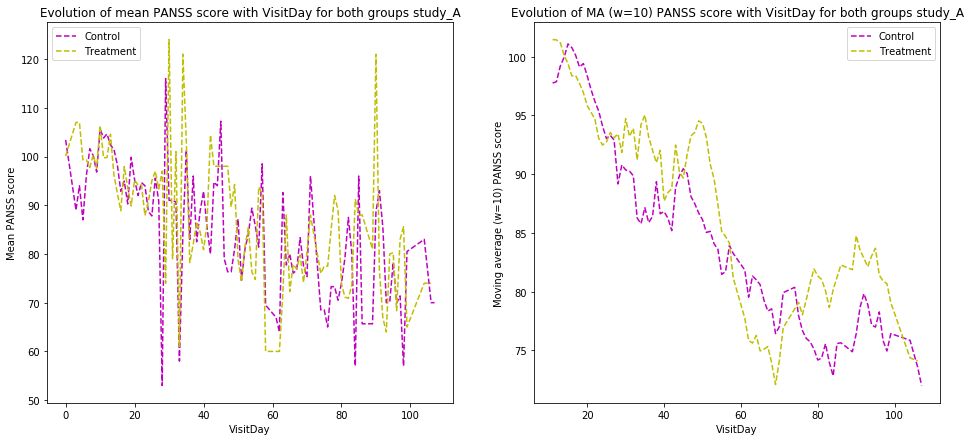

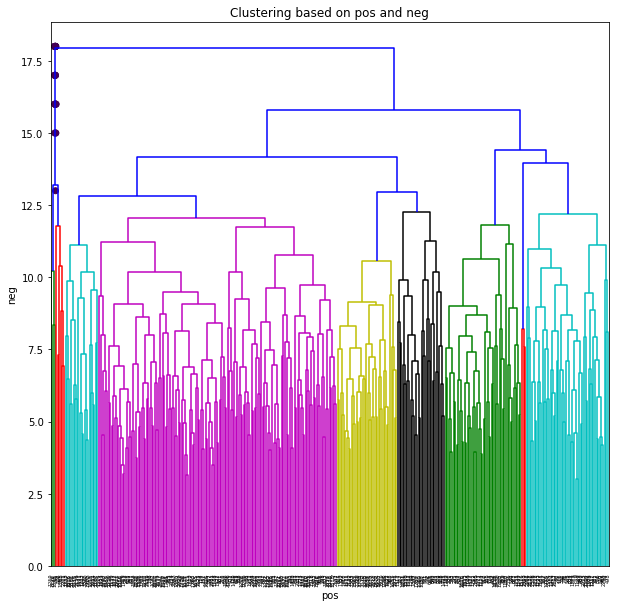

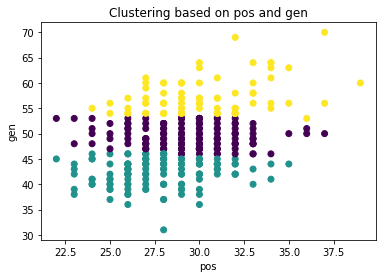

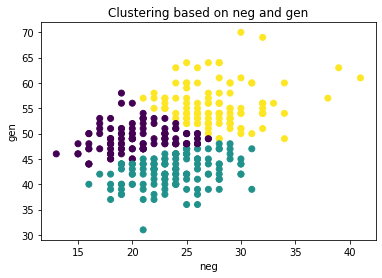

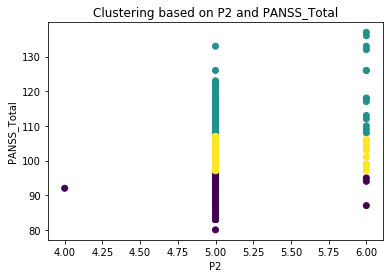

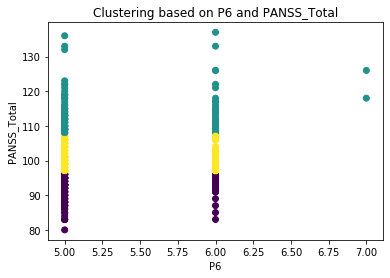

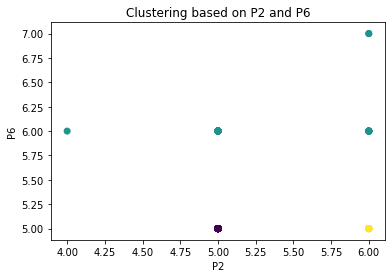

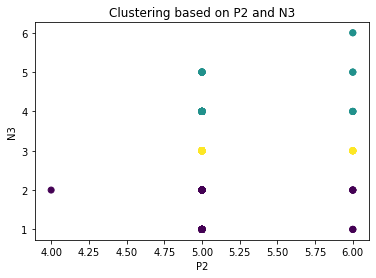

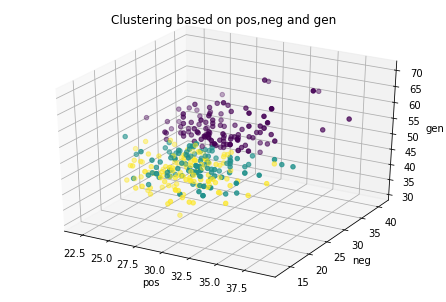

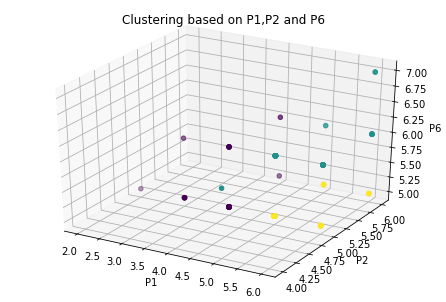

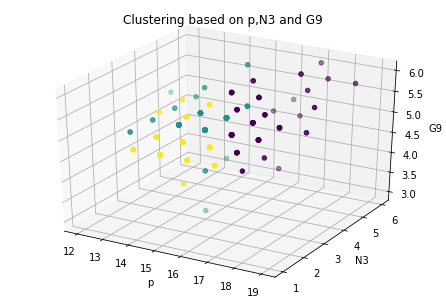

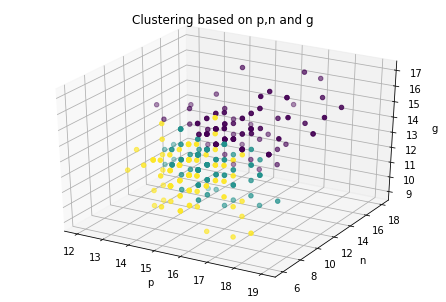

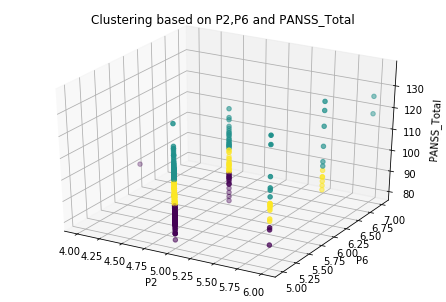

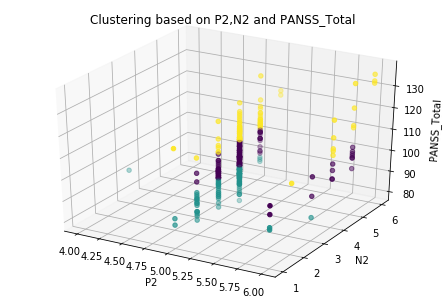

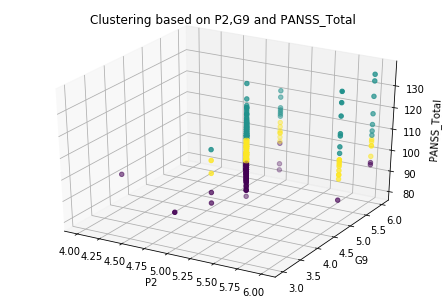

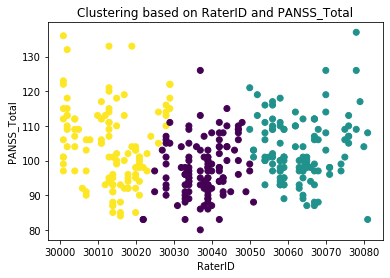

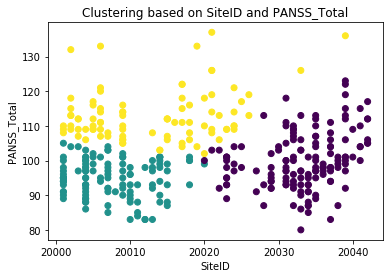

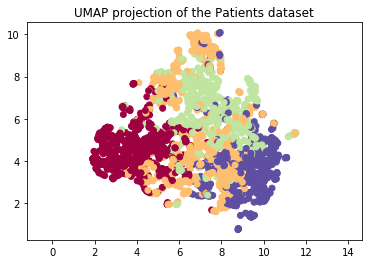

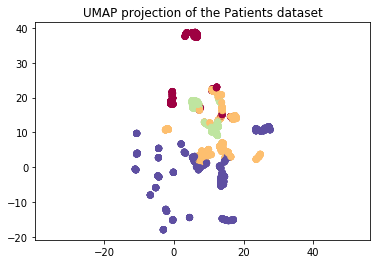

In [29]:
study_A = Study(name = 'A')
study_A.preprocess(False, False, False)
study_A.drug_effect(True, True)
study_A.classify_patients()
study_A.umap()

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     287.0
Date:                Wed, 12 Aug 2020   Prob (F-statistic):          1.41e-104
Time:                        23:15:44   Log-Likelihood:                -5579.2
No. Observations:                1351   AIC:                         1.116e+04
Df Residuals:                    1348   BIC:                         1.118e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           84.6144      0.612  

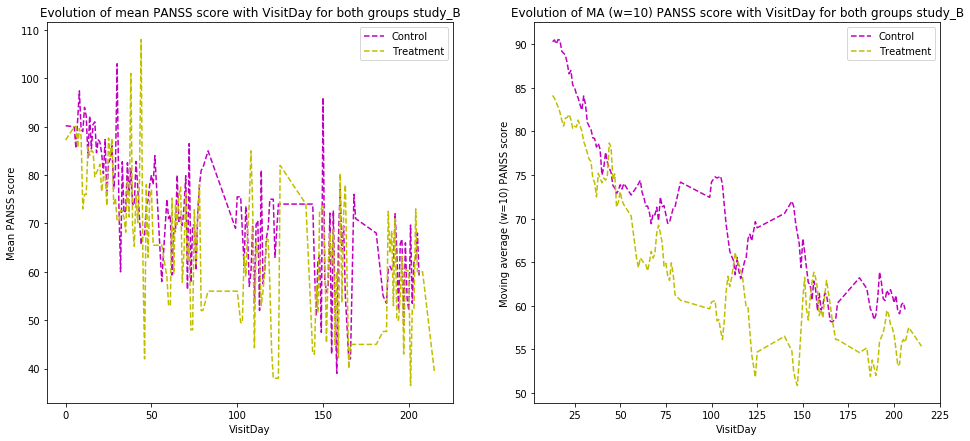

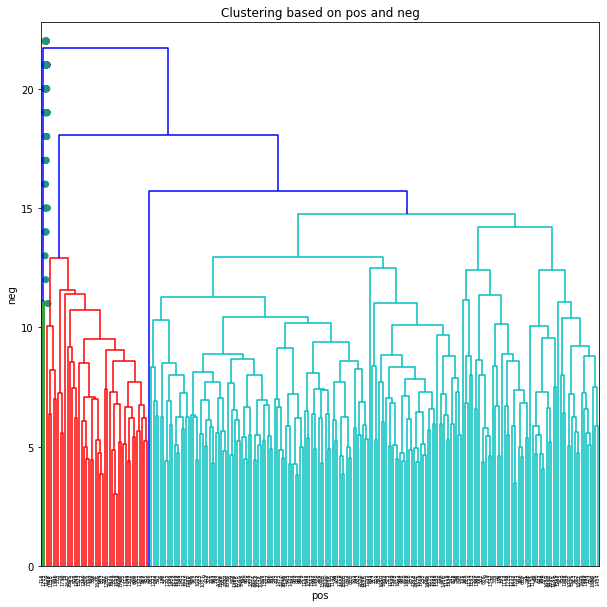

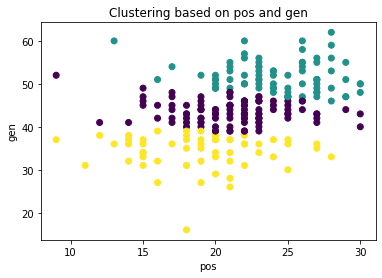

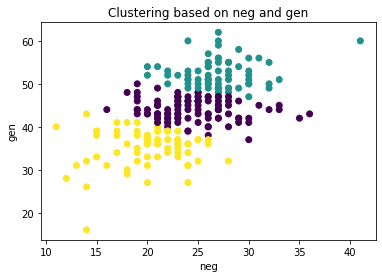

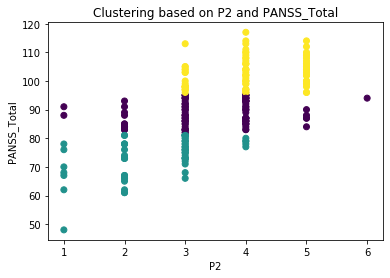

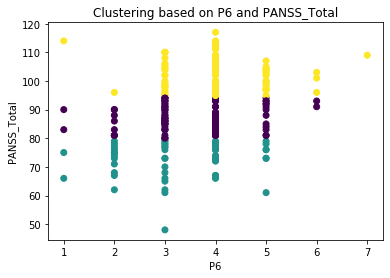

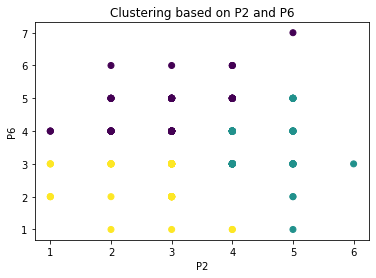

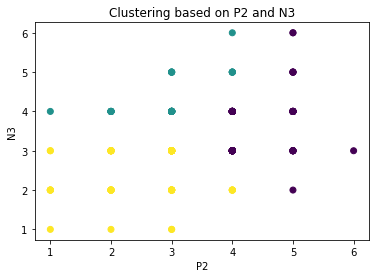

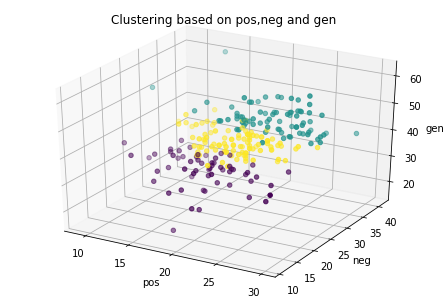

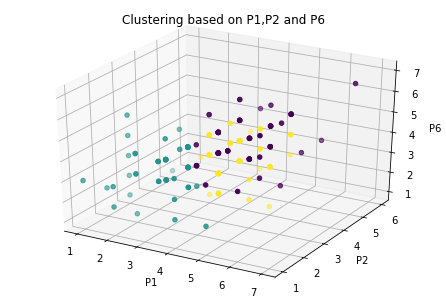

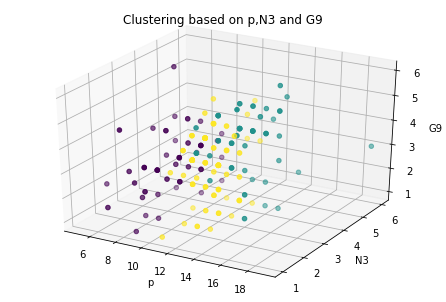

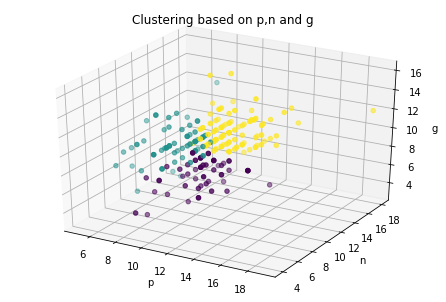

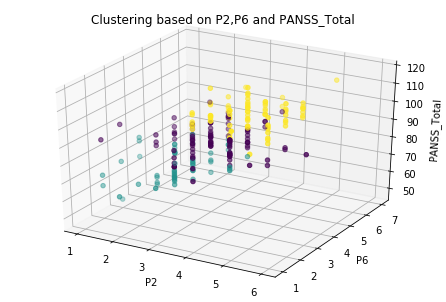

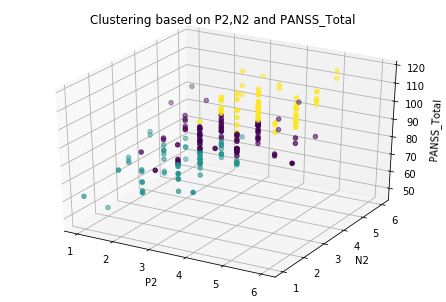

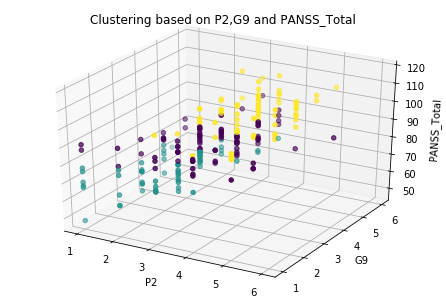

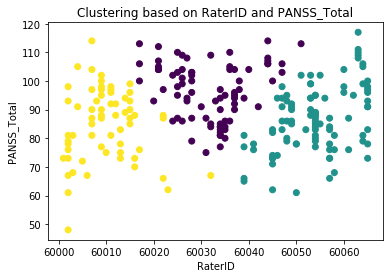

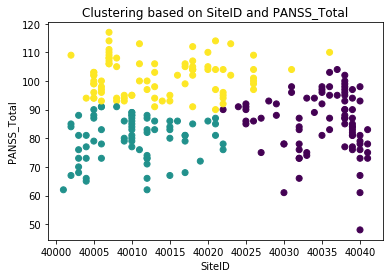

In [30]:
study_B = Study(name = 'B')
study_B.preprocess(False,False, False)
study_B.drug_effect(True, True)
study_B.classify_patients()

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     4503.
Date:                Wed, 12 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:16:55   Log-Likelihood:                -50331.
No. Observations:               12637   AIC:                         1.007e+05
Df Residuals:                   12634   BIC:                         1.007e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           80.1286      0.169  

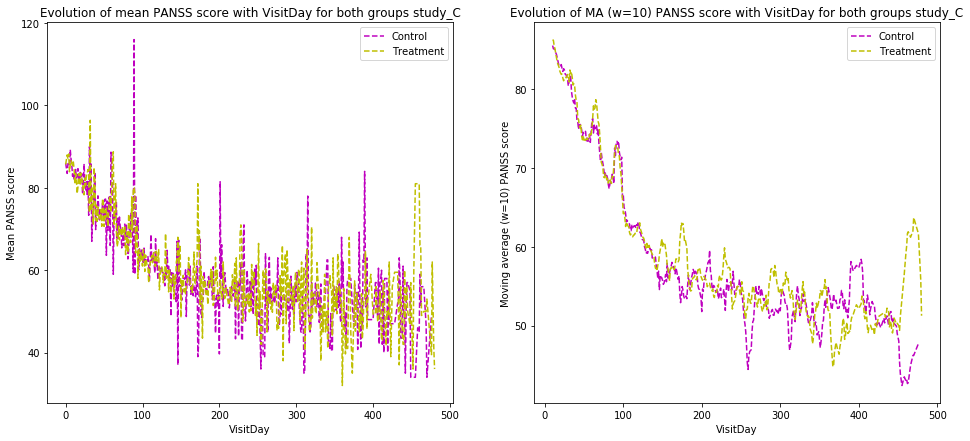

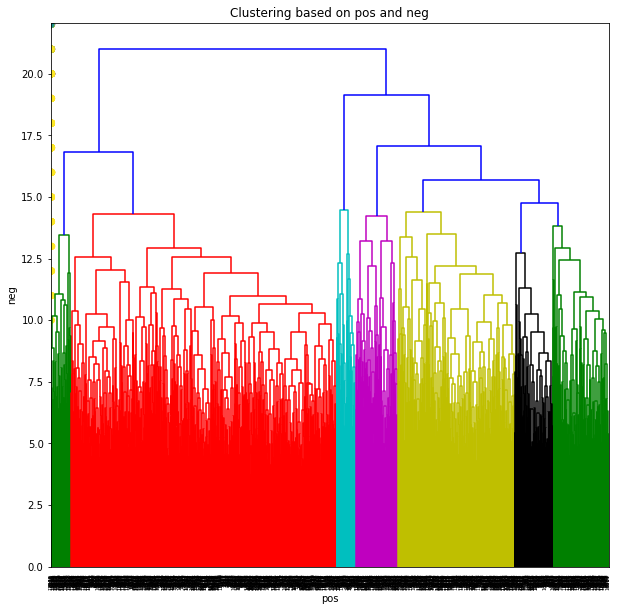

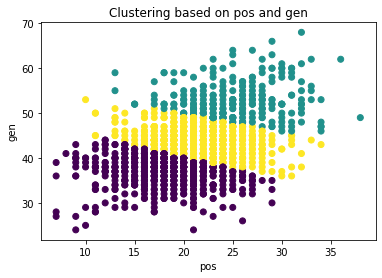

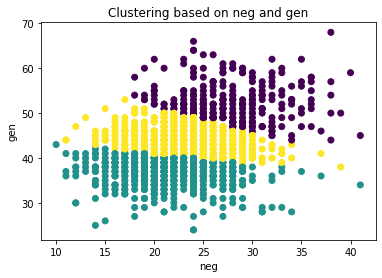

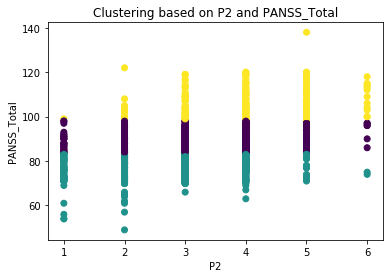

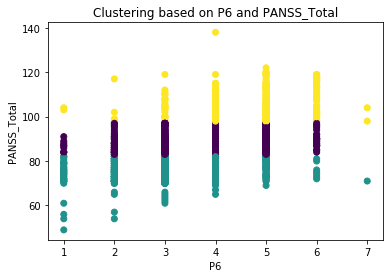

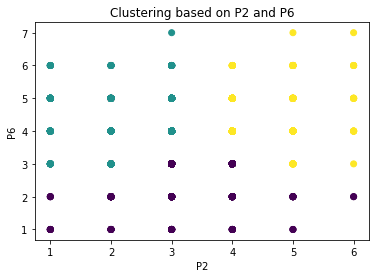

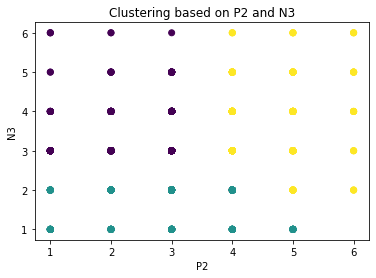

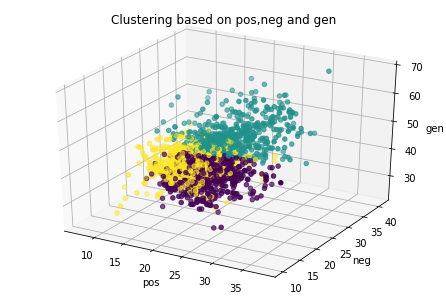

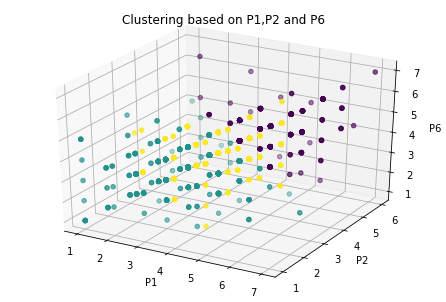

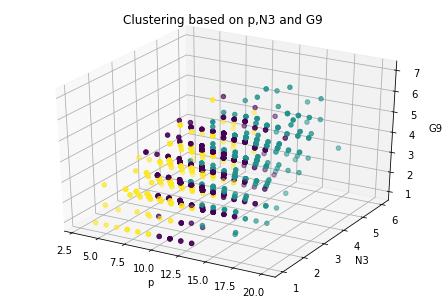

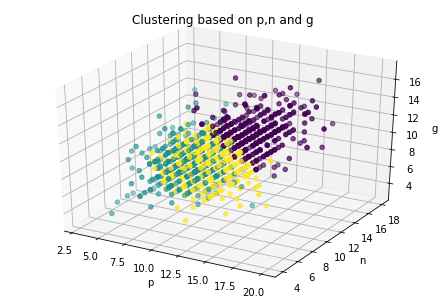

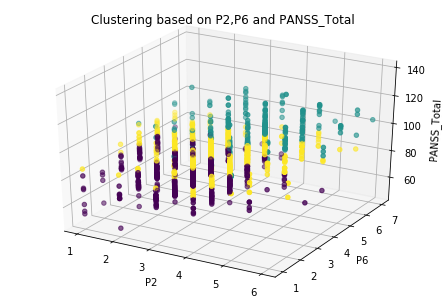

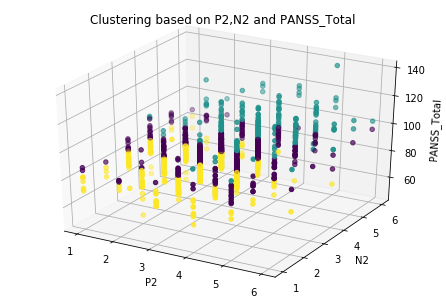

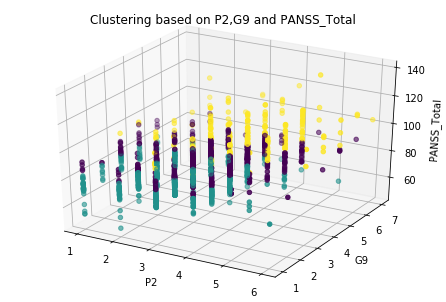

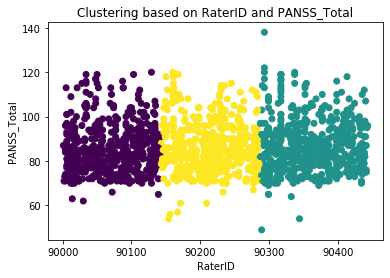

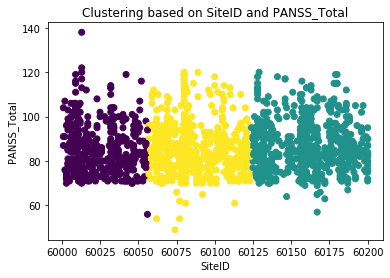

In [31]:
study_C = Study(name = 'C')
study_C.preprocess(False, False, False)
study_C.drug_effect(True, True)
study_C.classify_patients()

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     35.78
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           8.63e-15
Time:                        23:19:39   Log-Likelihood:                -1382.4
No. Observations:                 333   AIC:                             2771.
Df Residuals:                     330   BIC:                             2782.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           75.8920      1.140  

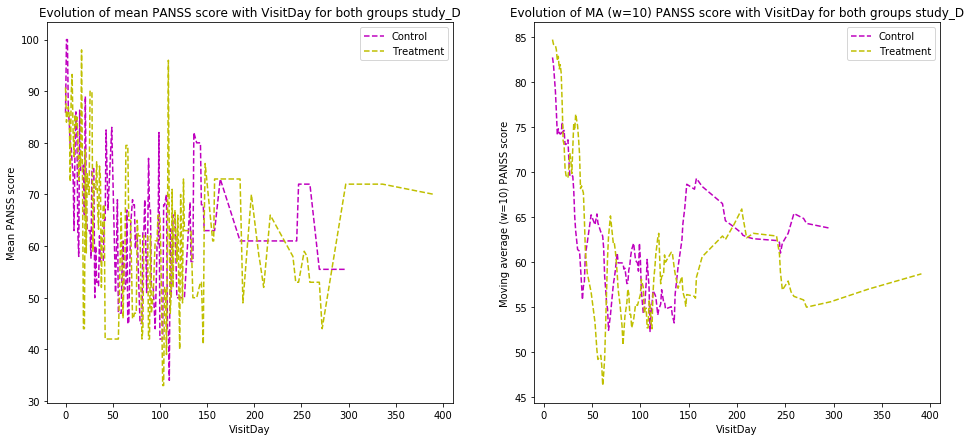

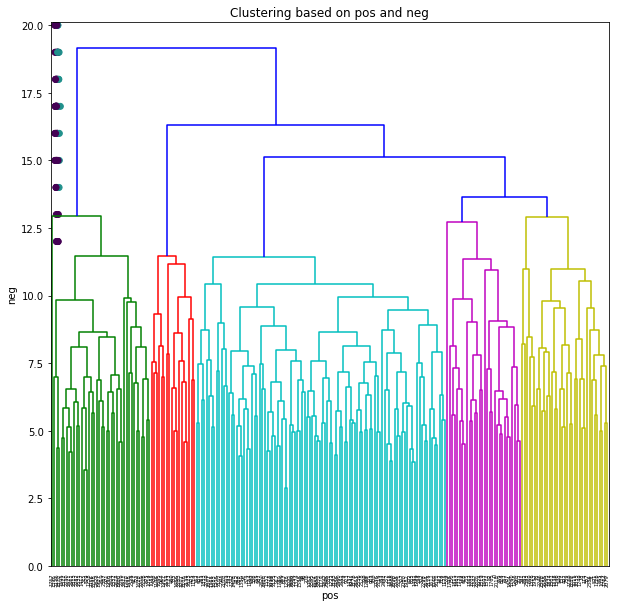

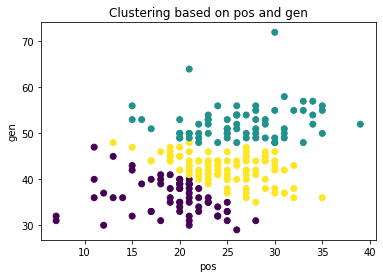

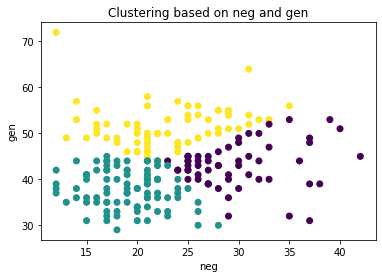

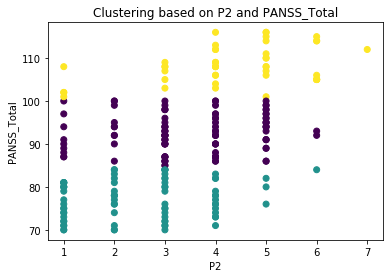

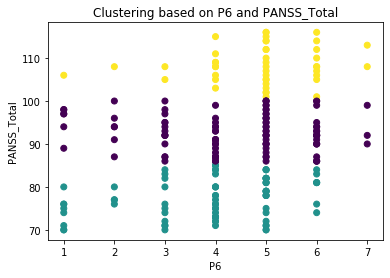

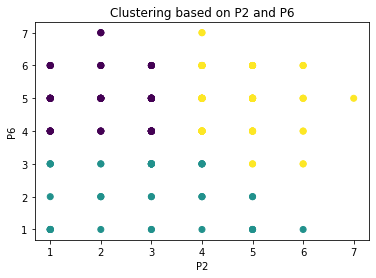

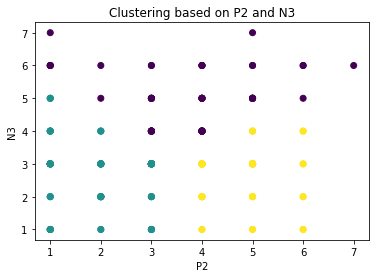

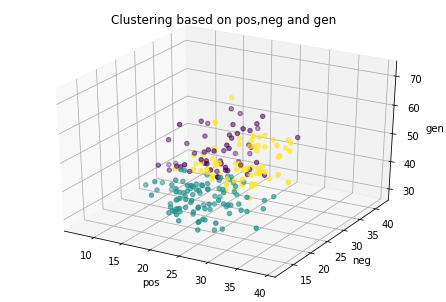

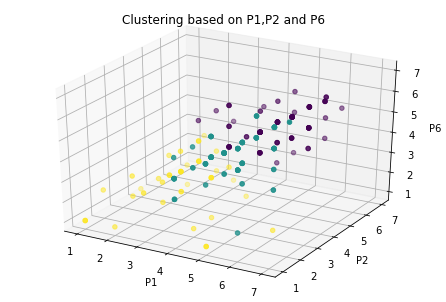

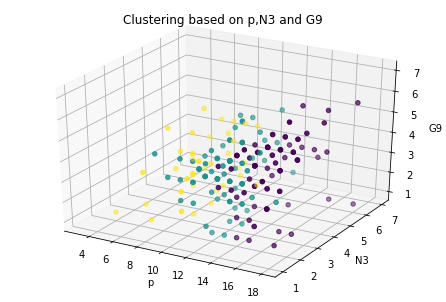

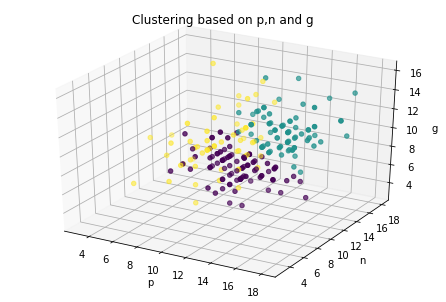

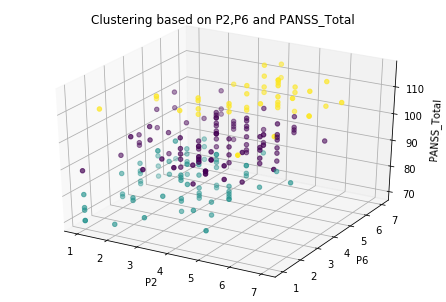

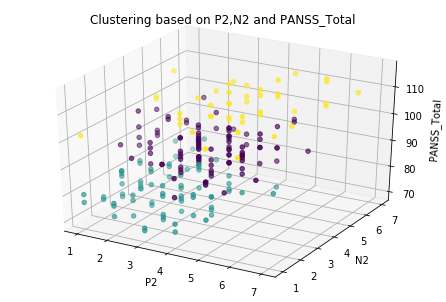

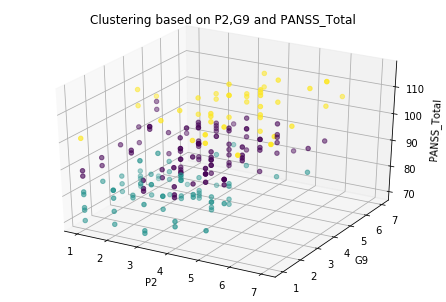

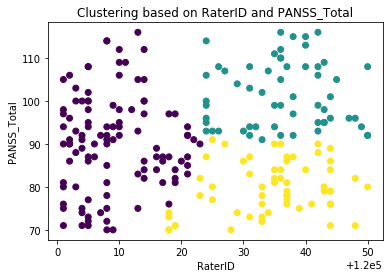

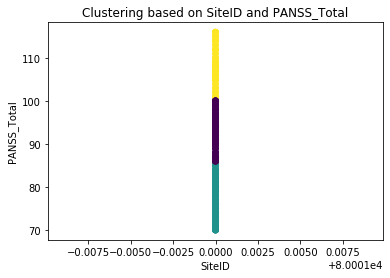

In [32]:
study_D = Study(name = 'D')
study_D.preprocess(False, False, False)
study_D.drug_effect(True, True)
study_D.classify_patients()

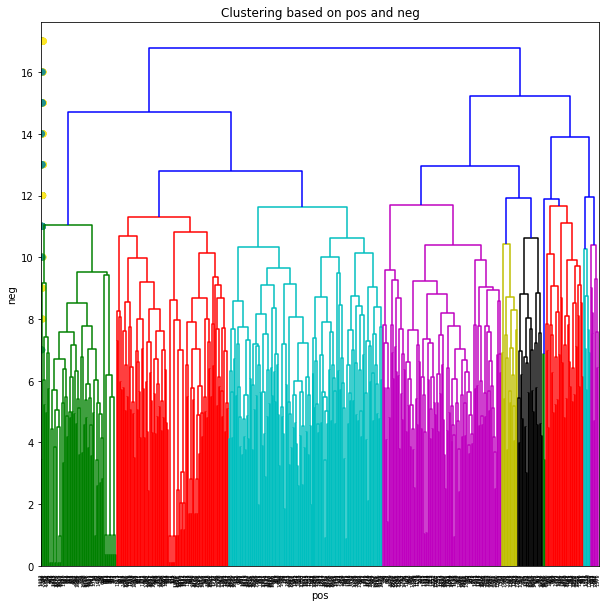

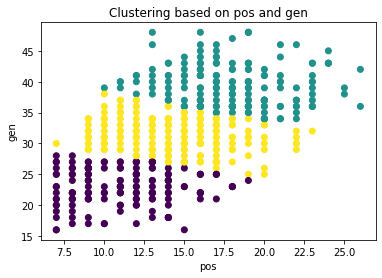

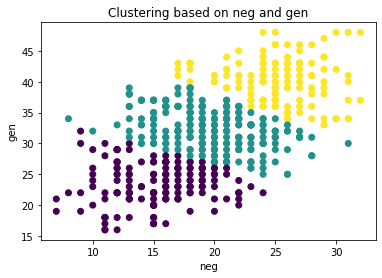

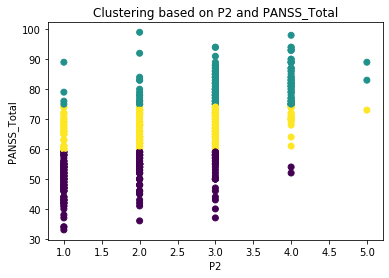

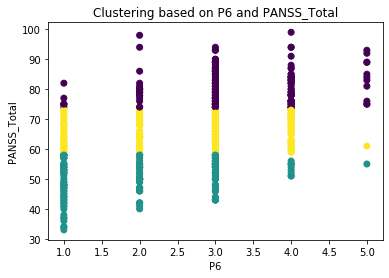

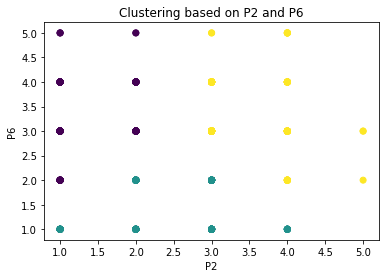

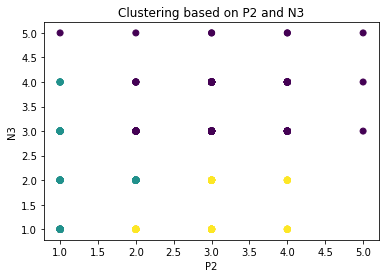

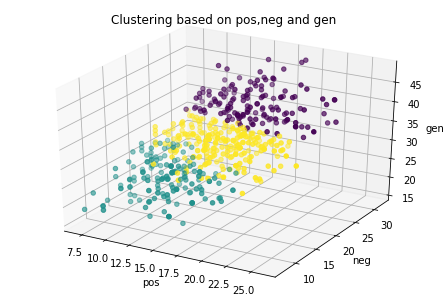

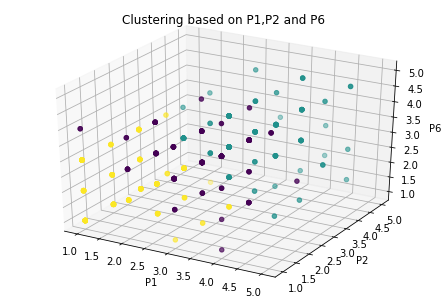

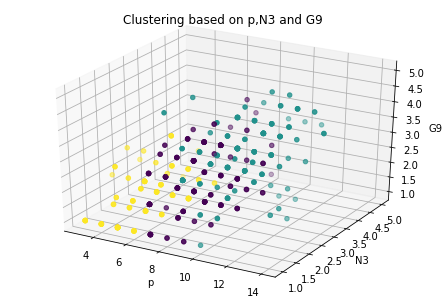

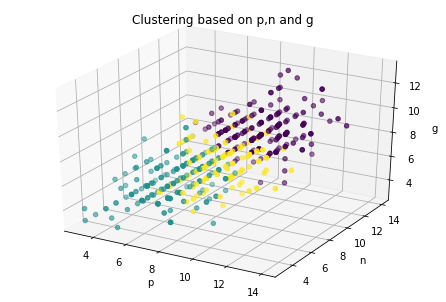

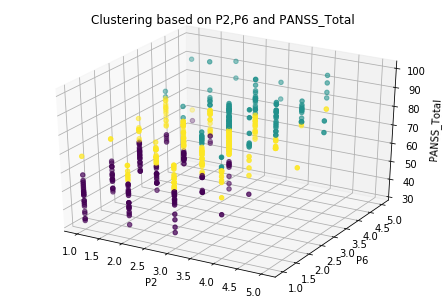

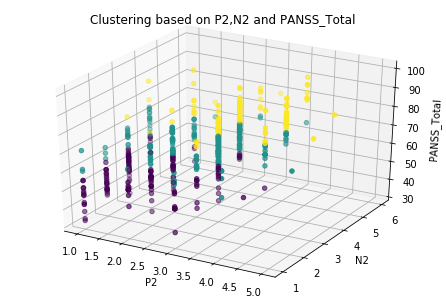

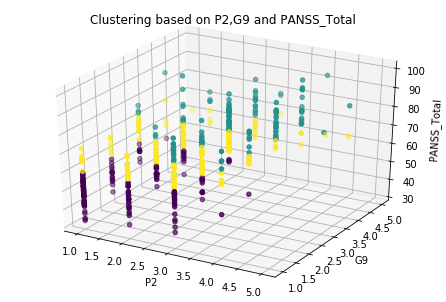

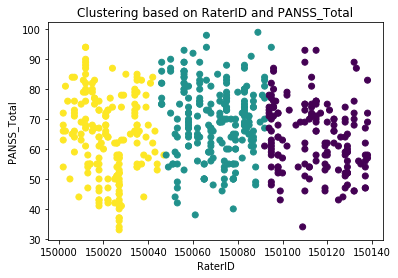

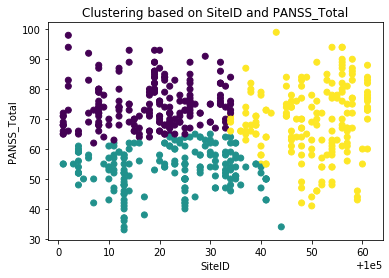

In [34]:
study_E = Study(name = 'E')
study_E.preprocess(False, False, False)
study_E.drug_effect(True, True)
study_E.classify_patients()

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     5213.
Date:                Wed, 12 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:23:02   Log-Likelihood:                -64290.
No. Observations:               15800   AIC:                         1.286e+05
Df Residuals:                   15797   BIC:                         1.286e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           82.4672      0.160  

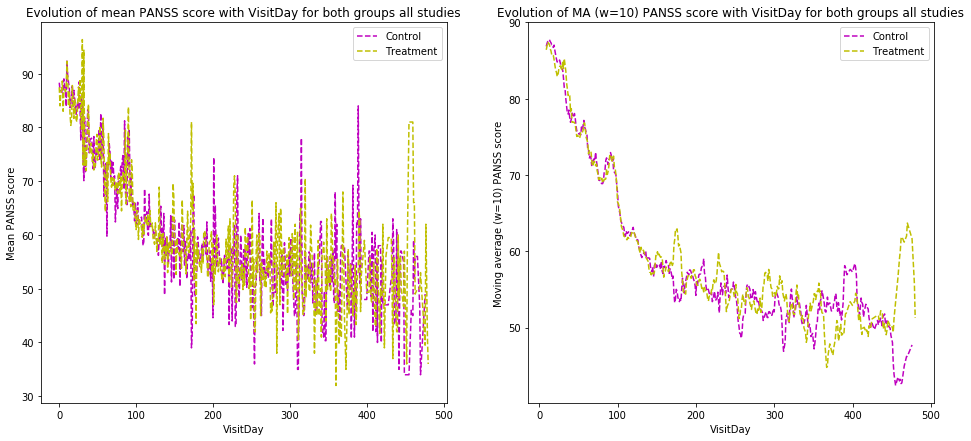

In [35]:
studies = [study_A, study_B, study_C, study_D, study_E]
drug_eff(studies[:-1])

In [36]:
featToexclude = ['Study', 'Country', 'AssessmentID','LeadStatus', 'PANSS_Total',
                 'LeadStatus_Assign to CS', 'LeadStatus_Flagged', 'LeadStatus_Passed',
                 'P3','P4','P5','P7','N1','N4','N6','N7','G1','G2','G3','G4','G5','G6',
                 'G7','G8','G10','G11','G12','G13','G14', "pos", "neg", "gen", "RaterID", "SiteID"]
featToexclude = ['Study', 'Country', 'AssessmentID','LeadStatus','PANSS_Total',
                 'LeadStatus_Assign to CS', 'LeadStatus_Flagged', 'LeadStatus_Passed',
                 "pos", "neg", "gen", "RaterID", "SiteID"]

features = ['P1','P2','P3', 'P4', 'P5','P6','P7','N1','N2','N3','N4','N5','N6','N7',
            'G1','G2','G4','G3','G4','G5','G6','G7','G8','G9', 'G10','G11','G12','G13',
            'G14','G15','G16']

In [ ]:
#forcasting:
forecast(studies, featToexclude, "feat_eng_alltrain_X", granular = True, pca = False,
                alltrain = False, allstudies = False, featEng = True)

Training the model for P1
Training the model for P2
Training the model for P3


In [ ]:
#forcasting ElasticNet regression:
forcaast_LR(studies, featToexclude, "LR_feat_eng_alltrain_woPanss", featEng = True,
                                    allstudies = False, alltrain = True, granular=False)

In [ ]:
#Predicting and ensembling:
predict("models/xgb", "no_feat_eng_alltrain_woPanss", features, study_E, featToexclude, oneModel = 0)
ensembling(["feat_eng_alltrain_X", "feat_eng_alltrain_woPanss"], features, featToexclude, study_E)

In [ ]:
#Classification:
featToexclude = ['Study', 'Country']
classification(studies, featToexclude)